# <center>Inverse Autoregressive Flow [1]</center>

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

import sklearn.datasets as datasets

from NF_base import *

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

**Inverse Autoregressive Flows:**

\begin{equation*}
    \forall i\in\{1,...,d\},\ x_i = T_i(z) = \mu(z_{1:i-1})+\sigma(z_{1:i-1})\odot z_i
\end{equation*}
Thus, $\det J_T(z) = \prod_{i=1}^d \sigma_i(z)$.

(when in MAF, we have:

\begin{equation*}
    z_i = \exp(-\alpha_i(x_{1:i-1}))(x_i-\mu_i(x_{1:i-1}))
\end{equation*}
)

In [ ]:
## https://github.com/karpathy/pytorch-normalizing-flows/blob/master/nflib/made.py

class MaskedLinear(nn.Linear):
    """ same as Linear except has a configurable mask on the weights """
    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

class MADE(nn.Module):
    def __init__(self, nin, hidden_sizes, nout, num_masks=1, natural_ordering=False):
        """
        nin: integer; number of inputs
        hidden sizes: a list of integers; number of units in hidden layers
        nout: integer; number of outputs, which usually collectively parameterize some kind of 1D distribution
              note: if nout is e.g. 2x larger than nin (perhaps the mean and std), then the first nin
              will be all the means and the second nin will be stds. i.e. output dimensions depend on the
              same input dimensions in "chunks" and should be carefully decoded downstream appropriately.
              the output of running the tests for this file makes this a bit more clear with examples.
        num_masks: can be used to train ensemble over orderings/connections
        natural_ordering: force natural ordering of dimensions, don't use random permutations
        """
        
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.hidden_sizes = hidden_sizes
        assert self.nout % self.nin == 0, "nout must be integer multiple of nin"
        
        # define a simple MLP neural net
        self.net = []
        hs = [nin] + hidden_sizes + [nout]
        for h0,h1 in zip(hs, hs[1:]):
            self.net.extend([
                    MaskedLinear(h0, h1),
                    nn.ReLU(),
                ])
        self.net.pop() # pop the last ReLU for the output layer
        self.net = nn.Sequential(*self.net)
        
        # seeds for orders/connectivities of the model ensemble
        self.natural_ordering = natural_ordering
        self.num_masks = num_masks
        self.seed = 0 # for cycling through num_masks orderings
        
        self.m = {}
        self.update_masks() # builds the initial self.m connectivity
        # note, we could also precompute the masks and cache them, but this
        # could get memory expensive for large number of masks.
        
    def update_masks(self):
        if self.m and self.num_masks == 1: return # only a single seed, skip for efficiency
        L = len(self.hidden_sizes)
        
        # fetch the next seed and construct a random stream
        rng = np.random.RandomState(self.seed)
        self.seed = (self.seed + 1) % self.num_masks
        
        # sample the order of the inputs and the connectivity of all neurons
        self.m[-1] = np.arange(self.nin) if self.natural_ordering else rng.permutation(self.nin)
        for l in range(L):
            self.m[l] = rng.randint(self.m[l-1].min(), self.nin-1, size=self.hidden_sizes[l])
        
        # construct the mask matrices
        masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
        masks.append(self.m[L-1][:,None] < self.m[-1][None,:])
        
        # handle the case where nout = nin * k, for integer k > 1
        if self.nout > self.nin:
            k = int(self.nout / self.nin)
            # replicate the mask across the other outputs
            masks[-1] = np.concatenate([masks[-1]]*k, axis=1)
        
        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l,m in zip(layers, masks):
            l.set_mask(m)
    
    def forward(self, x):
        return self.net(x)


class ARMLP(nn.Module):
    """ a 4-layer auto-regressive MLP, wrapper around MADE net """

    def __init__(self, nin, nh, nout, n_layers=3):
        super().__init__()
        self.net = MADE(nin, [nh for i in range(3)], nout, num_masks=1, natural_ordering=True)
        
    def forward(self, x):
        return self.net(x)

In [ ]:
class IAF(BaseNormalizingFlow):
    """
        Inverse Autoregressive Flow
    """
    def __init__(self, net):
        """
            net must be a MADE net (i.e. with mask on the rights connections)
        """
        super().__init__()
        self.net = net

    def forward(self, z):
        output = self.net(z)
        alpha, mu = output[:,:output.size(1)//2], output[:,output.size(1)//2:]

        x = z*torch.exp(alpha)+mu
        log_det = torch.sum(alpha, dim=1)
        
        return x, log_det

    def backward(self, x):
        z = torch.zeros(x.size(),device=device)
        log_det = torch.zeros(x.size(0),device=device)

        for i in range(x.size(1)):
            output = self.net(z)
            alpha, mu = output[:,:output.size(1)//2], output[:,output.size(1)//2:]
            z[:,i] = (x[:,i]-mu[:,i])*torch.exp(-alpha[:,i])
            log_det -= alpha[:,i]
            
        return z, log_det

## Unnormalized 2D densities

Target: $p(z)\propto e^{-U(z)}$

In [ ]:
## https://arxiv.org/pdf/1505.05770.pdf

def sigmoid(z):
    return 1/(1+np.exp(-z))

def sigmoidp(z):
    return 1/(1+torch.exp(-z))

def w1(z):
    return np.sin(2*np.pi*z[:,0]/4)

def w1p(z):
    return torch.sin(2*np.pi*z[:,0]/4)

def w2(z):
    cpt = ((z[:,0]-1)/0.6)**2
    return 3*np.exp(-0.5*cpt)

def w2p(z):
    cpt = ((z[:,0]-1)/0.6)**2
    return 3*torch.exp(-0.5*cpt)

def w3(z):
    return 3*sigmoid((z[:,0]-1)/3)

def w3p(z):
    return 3*sigmoidp((z[:,0]-1)/3)

def U1(z):
    cpt1 = ((np.linalg.norm(z,axis=1)-2)/0.4)**2
    cpt2 = -0.5*((z[:,0]-2)/0.6)**2
    cpt3 = -0.5*((z[:,0]+2)/0.6)**2
    return cpt1-np.log(np.exp(cpt2)+np.exp(cpt3))

def U1p(z):
    cpt1 = ((torch.sqrt(z[:,0]**2+z[:,1]**2)-2)/0.4)**2
    cpt1 = ((torch.sqrt(torch.sum(z**2,dim=1))-2)/0.4)**2
    cpt2 = -0.5*((z[:,0]-2)/0.6)**2
    cpt3 = -0.5*((z[:,0]+2)/0.6)**2
    return cpt1-torch.log(torch.clamp(torch.exp(cpt2)+torch.exp(cpt3),min=1e-6))

def U2(z):
    return 0.5*((z[:,1]-w1(z))/0.4)**2

def U2p(z):
    return 0.5*((z[:,1]-w1p(z))/0.4)**2

def U3(z):
    cpt1 = ((z[:,1]-w1(z))/0.35)**2
    cpt2 = ((z[:,1]-w1(z)+w2(z))/0.35)**2
    return -np.log(np.exp(-0.5*cpt1)+np.exp(-0.5*cpt2))

def U3p(z):
    cpt1 = ((z[:,1]-w1p(z))/0.35)**2
    cpt2 = ((z[:,1]-w1p(z)+w2p(z))/0.35)**2
    return -torch.log(torch.clamp(torch.exp(-0.5*cpt1)+torch.exp(-0.5*cpt2),min=1e-6))

def U4(z):
    cpt1 = ((z[:,1]-w1(z))/0.4)**2
    cpt2 = ((z[:,1]-w1(z)+w3(z))/0.35)**2
    return -np.log(np.exp(-0.5*cpt1)+np.exp(-0.5*cpt2))

def U4p(z):
    cpt1 = ((z[:,1]-w1p(z))/0.4)**2
    cpt2 = ((z[:,1]-w1p(z)+w3p(z))/0.35)**2
    return -torch.log(torch.clamp(torch.exp(-0.5*cpt1)+torch.exp(-0.5*cpt2),min=1e-6))

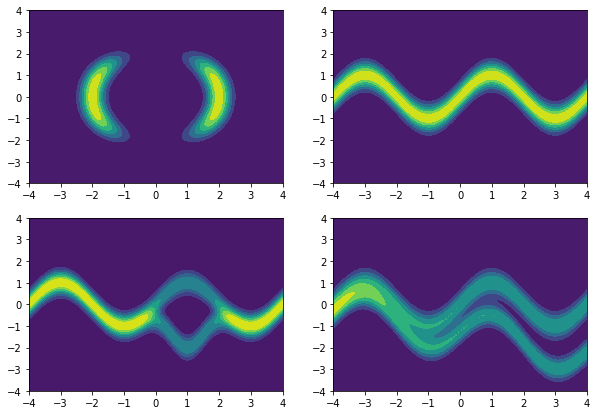

In [ ]:
xline = np.linspace(-4, 4, 100)
yline = np.linspace(-4, 4, 100)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)

zz = np.exp(-U1(xyinput)) # np.exp(-xyinput.sum(axis=1))
zgrid1 = zz.reshape(100,100)

zz = np.exp(-U2(xyinput)) # np.exp(-xyinput.sum(axis=1))
zgrid2 = zz.reshape(100,100)

zz = np.exp(-U3(xyinput)) # np.exp(-xyinput.sum(axis=1))
zgrid3 = zz.reshape(100,100)

zz = np.exp(-U4(xyinput)) # np.exp(-xyinput.sum(axis=1))
zgrid4 = zz.reshape(100,100)

fig,ax = plt.subplots(2,2,figsize=(10,7))

ax[0,0].contourf(xgrid, ygrid, zgrid1)
ax[0,1].contourf(xgrid, ygrid, zgrid2)
ax[1,0].contourf(xgrid, ygrid, zgrid3)
ax[1,1].contourf(xgrid, ygrid, zgrid4)
plt.show()

In [ ]:
def kl_reverse(z,x,log_det,true_density):
    log_pz = base_distr.log_prob(z)
    log_pX = torch.log(torch.clamp(true_density(x),min=1e-20)) ## only need unnormalized density
    return torch.mean(log_pz-log_det-log_pX,dim=0)

In [ ]:
def train_shapes(model,n_batch=500,n_epochs=10001,U=U1p):
    true_density = lambda x : torch.exp(-U(x))

    train_loss = []

    for i in range(n_epochs):
        if i%100==0:
            print(i)

        model.train()

        z0 = torch.randn(n_batch,2,device=device)
        xs,log_det = model(z0)

        loss = kl_reverse(z0,xs[-1],log_det,true_density)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(loss.item())
        if i%100==0:
            print(loss)

    return train_loss

In [ ]:
base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
    torch.zeros(2,device=device),torch.eye(2,device=device))

### $U_1$

In [ ]:
d = 2

nets = [ARMLP(d,24,2*d,3) for k in range(5)]

flows = []
for i in range(5):
    flows.append(IAF(nets[i]))
    flows.append(Reverse(d))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  6860


In [ ]:
train_loss = train_shapes(model,U=U1p,n_epochs=2001)

0
tensor(3.9105, device='cuda:0', grad_fn=<MeanBackward1>)
100
tensor(3.7266, device='cuda:0', grad_fn=<MeanBackward1>)
200
tensor(3.5273, device='cuda:0', grad_fn=<MeanBackward1>)
300
tensor(3.3703, device='cuda:0', grad_fn=<MeanBackward1>)
400
tensor(3.7985, device='cuda:0', grad_fn=<MeanBackward1>)
500
tensor(3.0939, device='cuda:0', grad_fn=<MeanBackward1>)
600
tensor(3.1069, device='cuda:0', grad_fn=<MeanBackward1>)
700
tensor(1.9788, device='cuda:0', grad_fn=<MeanBackward1>)
800
tensor(1.0071, device='cuda:0', grad_fn=<MeanBackward1>)
900
tensor(0.2610, device='cuda:0', grad_fn=<MeanBackward1>)
1000
tensor(-0.0878, device='cuda:0', grad_fn=<MeanBackward1>)
1100
tensor(-0.5359, device='cuda:0', grad_fn=<MeanBackward1>)
1200
tensor(-0.9654, device='cuda:0', grad_fn=<MeanBackward1>)
1300
tensor(-1.2034, device='cuda:0', grad_fn=<MeanBackward1>)
1400
tensor(-1.2492, device='cuda:0', grad_fn=<MeanBackward1>)
1500
tensor(-1.3383, device='cuda:0', grad_fn=<MeanBackward1>)
1600
tensor(-1

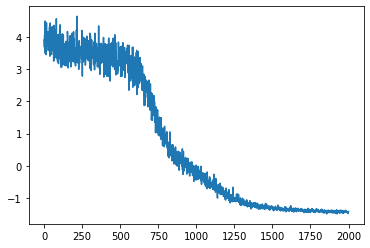

In [ ]:
plt.plot(train_loss)
plt.show()

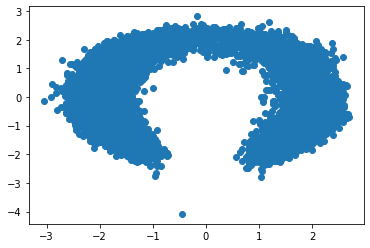

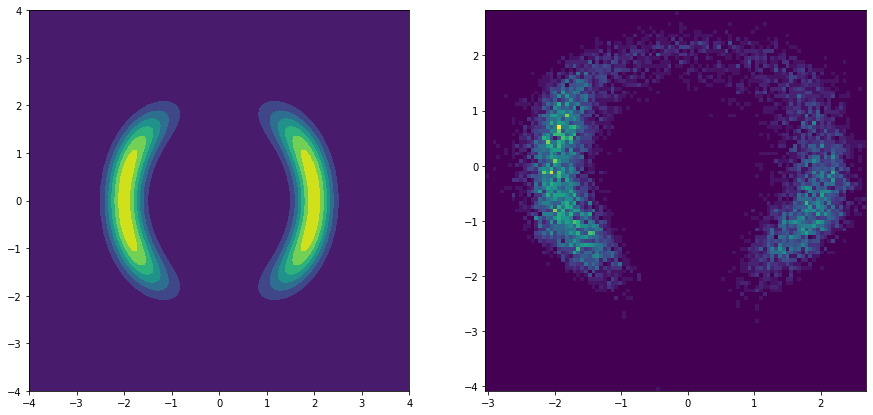

In [ ]:
z,_ = model(torch.randn(10000,2,device=device))
samples = z[-1].detach().cpu().numpy()

plt.scatter(samples[:,0],samples[:,1])
plt.show()

fig,ax = plt.subplots(1,2,figsize=(15,7))

ax[0].contourf(xgrid, ygrid, zgrid1)
ax[1].hist2d(samples[:,0],samples[:,1],bins=100)
plt.show()

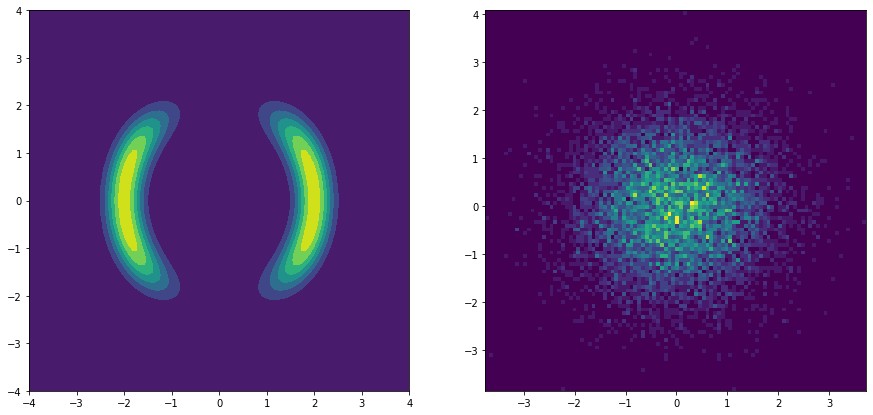

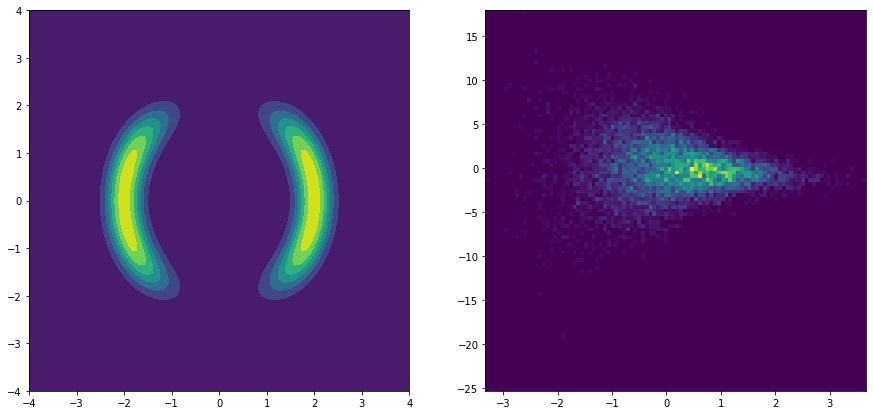

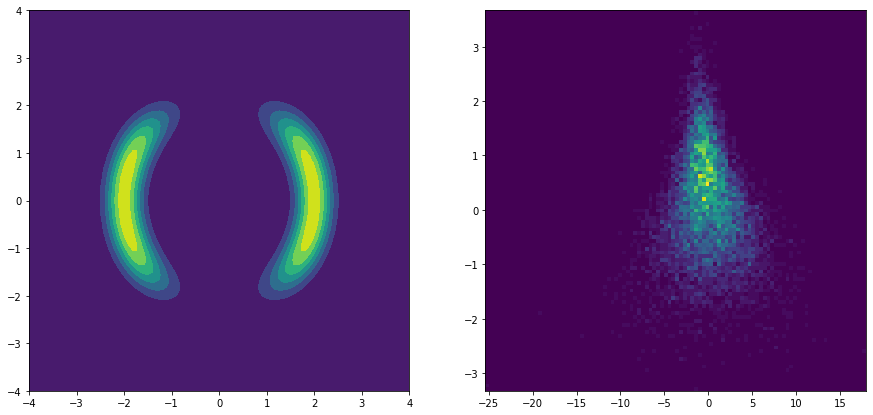

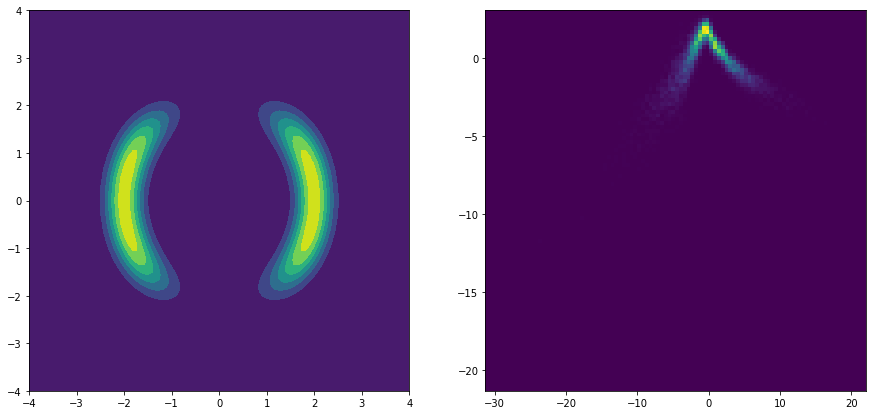

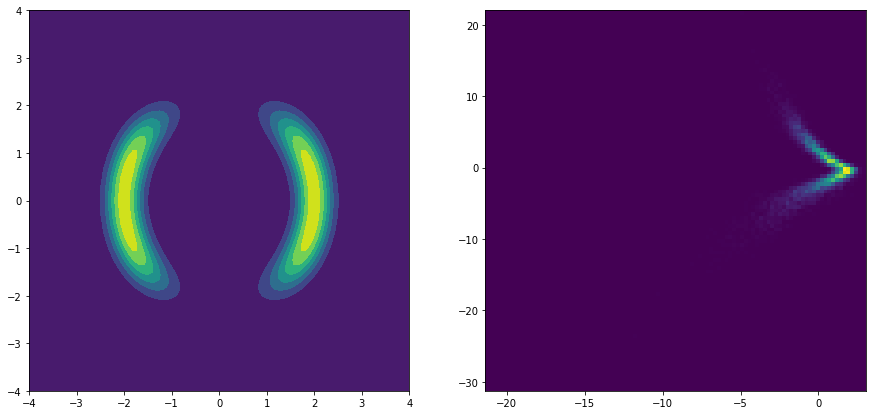

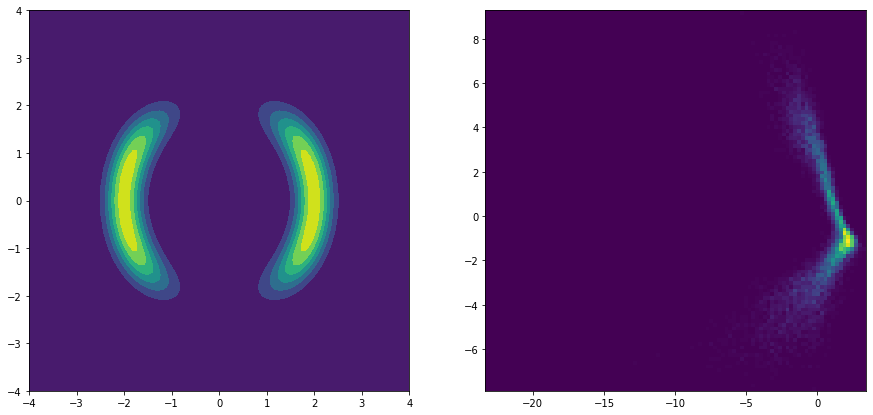

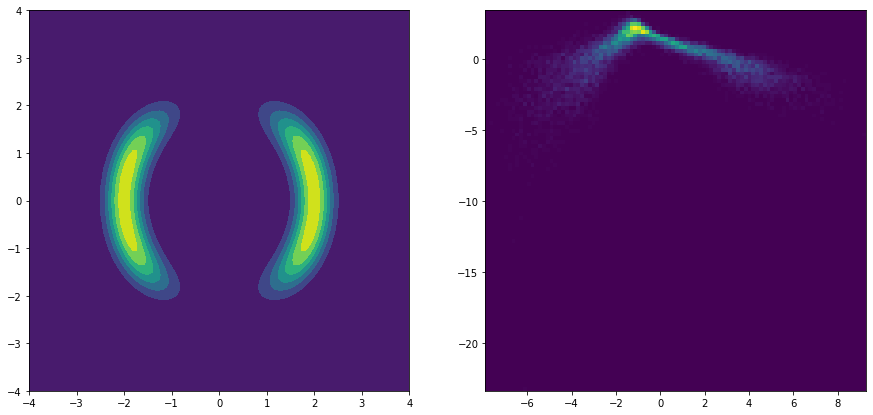

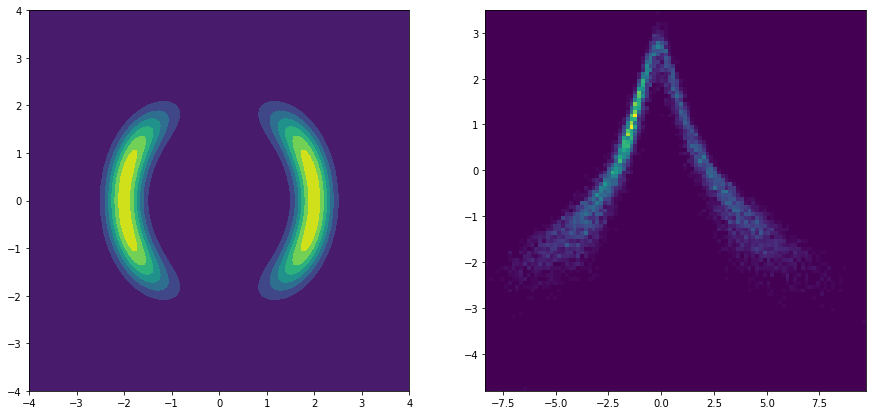

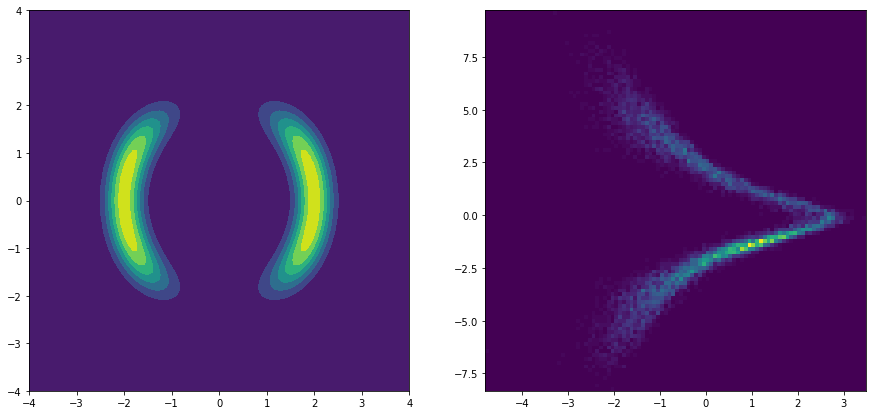

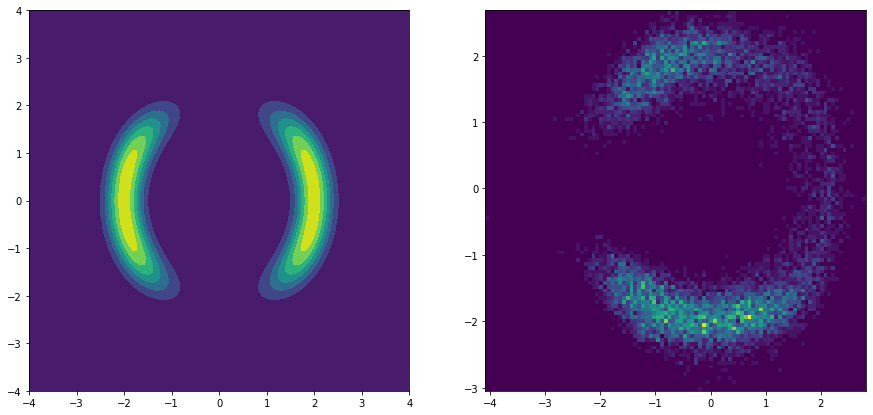

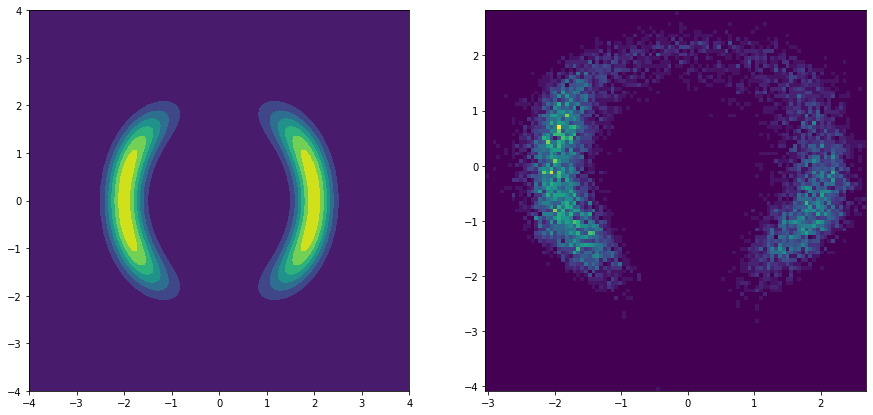

In [ ]:
for i in range(len(z)):
    sample = z[i].detach().cpu().numpy()
    fig,ax = plt.subplots(1,2,figsize=(15,7))

    ax[0].contourf(xgrid, ygrid, zgrid1)
    ax[1].hist2d(sample[:,0],sample[:,1],bins=100)
    plt.show()

### $U_2$

In [ ]:
d = 2

nets = [ARMLP(d,24,2*d,3) for k in range(5)]

flows = []
for i in range(5):
    flows.append(IAF(nets[i]))
    flows.append(Reverse(d))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  6860


In [ ]:
train_loss = train_shapes(model,U=U2p,n_epochs=2001 )

0
tensor(2.9454, device='cuda:0', grad_fn=<MeanBackward1>)
100
tensor(0.6259, device='cuda:0', grad_fn=<MeanBackward1>)
200
tensor(-0.2927, device='cuda:0', grad_fn=<MeanBackward1>)
300
tensor(-0.8705, device='cuda:0', grad_fn=<MeanBackward1>)
400
tensor(-1.0481, device='cuda:0', grad_fn=<MeanBackward1>)
500
tensor(-1.1114, device='cuda:0', grad_fn=<MeanBackward1>)
600
tensor(-1.2209, device='cuda:0', grad_fn=<MeanBackward1>)
700
tensor(-1.3009, device='cuda:0', grad_fn=<MeanBackward1>)
800
tensor(-1.3360, device='cuda:0', grad_fn=<MeanBackward1>)
900
tensor(-1.4438, device='cuda:0', grad_fn=<MeanBackward1>)
1000
tensor(-1.6159, device='cuda:0', grad_fn=<MeanBackward1>)
1100
tensor(-1.7122, device='cuda:0', grad_fn=<MeanBackward1>)
1200
tensor(-1.8072, device='cuda:0', grad_fn=<MeanBackward1>)
1300
tensor(-1.8669, device='cuda:0', grad_fn=<MeanBackward1>)
1400
tensor(-1.8721, device='cuda:0', grad_fn=<MeanBackward1>)
1500
tensor(-1.8920, device='cuda:0', grad_fn=<MeanBackward1>)
1600
t

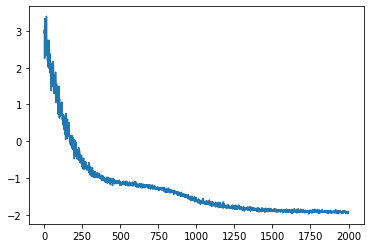

In [ ]:
plt.plot(train_loss)
plt.show()

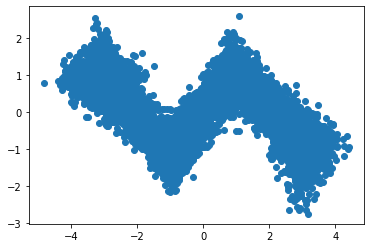

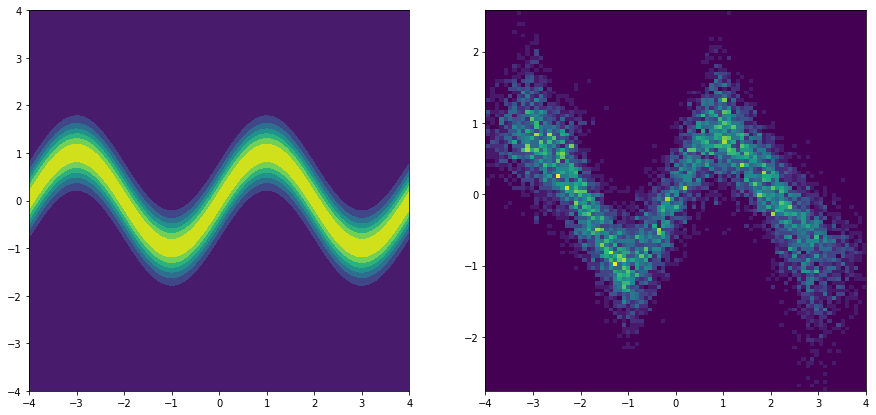

In [ ]:
samples,_ = model(torch.randn(10000,2,device=device))
samples = samples[-1].detach().cpu().numpy()

plt.scatter(samples[:,0],samples[:,1])
plt.show()

fig,ax = plt.subplots(1,2,figsize=(15,7))

ax[0].contourf(xgrid, ygrid, zgrid2)
ax[1].hist2d(samples[:,0],samples[:,1],bins=100)
ax[1].set_xlim(-4,4)
plt.show()

## Variational Encoder with NF

ELBO:
We have:
\begin{align*}
    \log p_\theta(x)&\geq \log p_\theta(x)-KL(q(\cdot|x)||p_\theta(\cdot|x))\\
    &= \int \log(\frac{p_\theta(x,z)}{q(z|x)})q(z|x)dz \\
    &= \mathbb{E}_{q(\cdot|x)}[p_\theta(x|z)]-KL(q(\cdot|x)||p_\theta) \\
    &= -\mathcal{F}(\theta)
\end{align*}

**Variational Encoder**:
- encoder: $q_\phi(z|x)$
- decoder: $p_\theta(x|z)$

Example for classical VAE:
- encoder: $q_\phi(z|x)=\mathcal{N}(z;\mu,\sigma^2 I)$
- apriori: $p_\theta(z)=\mathcal{N}(z;0,I)$
- decoder: $p_\theta(x|z)=\mathcal{N}(x;\mu(z),\sigma^2(z))$ or $p_\theta(x|z)=\text{Ber}(D(z))$

**VAE with NF**: 

Idea: improve the class of distribution for the variational inference with a normalizing flow in the latent space (e.g. not just a mean field approximation with gaussians anymore).

- $q_0(z|x)=\mathcal{N}(z;\mu(x),\sigma^2(x))$

Let $z_0\sim q_0(\cdot|x)$,

- $z_K = f_K\circ\dots\circ f_1(z_0) = f(z_0)$
- $q_K(z_K|x) = q_0(z_0|x)|\det J_f(f^{-1}(z_K))|^{-1}$
- $\log q_K(z_K|x) = \log q_0(z_0|x) - \sum_{k=1}^K \log |\det \frac{\partial f_k}{\partial z_{k-1}}(z_{k-1})|$

Then, denoting $q_\phi=q_K$, the ELBO transforms as:

\begin{align*}
    \mathcal{F}(\theta,\phi) &= \mathbb{E}_{q_\phi}[\log q_\phi(z|x)-\log p_\theta(x,z)] \\
    &= \mathbb{E}_{q_0}[\log q_0(z_0|x)-\log p_\theta(x,f(z_0))-\sum_{k=1}^K \log |\det \frac{\partial f_k}{\partial z_{k-1}}(z_{k-1})|]
\end{align*}

In [ ]:
def uniform_quantization(img):
    return (img*255+torch.rand(img.size()))/256

def rescale_logit(img,lambd=1e-6):
    ## logit space
    return torch.logit(lambd+(1-2*lambd)*img)

In [ ]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()#,
#                 uniform_quantization,
#                 rescale_logit
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

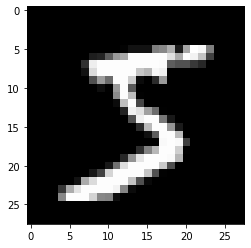

In [ ]:
plt.imshow(train_dataset[0][0].reshape(28,28),"gray")
plt.show()

In [ ]:
class Encoder(nn.Module):
    def __init__(self, d=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(28*28,512)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dense_mean = nn.Linear(512,d)
        self.dense_log_var = nn.Linear(512,d)
        
    def forward(self, x):
        z = self.flatten(x)
        z = self.dense(z)
        z = self.leaky_relu(z)
        z_mean = self.dense_mean(z)
        z_log_var = self.dense_log_var(z)
        return z_mean, z_log_var


class Decoder(nn.Module):
    def __init__(self,d=10):
        super().__init__()
        self.dense = nn.Linear(d,512)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dense2 = nn.Linear(512,28*28)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.dense(x)
        x = self.leaky_relu(x)
        x = self.dense2(x)
        x = self.sigmoid(x)
        return x.view(-1,28,28)
    
    
class VAE(nn.Module):
    def __init__(self,flow,d=10):
        super().__init__()
        self.encoder = Encoder(d)
        self.decoder = Decoder(d)
        self.flow = flow
    
    def forward(self, x):
        mu, log_sigma = self.encoder(x)        
        z0 = mu+torch.randn(mu.shape, device=device)*torch.exp(log_sigma)
        zKs, log_det = self.flow(z0)
        y = self.decoder(zKs[-1])
        return y, mu, log_sigma, log_det

In [ ]:
criterion = nn.BCELoss(reduction='sum')

def vae_loss(x, y, mu, log_sigma, log_det):    
    reconstruction_loss = criterion(y, x)
    kl_loss = -0.5*torch.sum(mu.pow(2)+log_sigma.exp()-log_sigma-1)
    
    return reconstruction_loss-kl_loss-log_det.sum()

In [ ]:
d = 10
nets = [ARMLP(d,24,2*d,3) for k in range(5)]

flows = []
for i in range(2):
    flows.append(IAF(nets[i]))
    flows.append(Reverse(d))

flow = NormalizingFlows(flows)

model = VAE(flow, d=10).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  823932


0 127.77462840131096 84.39188519072609


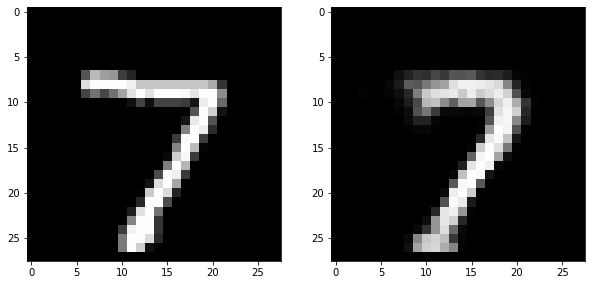

1 77.49978791150795 69.5884130069623
2 66.2264277574096 60.62998991652419
3 58.94079868829073 55.664692887863794
4 53.37978824759174 52.24327439621995
5 48.87478454145202 46.681678869472904
6 44.92369936337772 43.11321107419535
7 41.251181298142725 39.6000725011856
8 38.318121735898835 36.11780750408721
9 35.63635222998255 35.92661521838496
10 33.44196191610134 32.99100935573395
11 31.618409607540908 30.83360363652531
12 29.734615588916814 29.197335605804152
13 28.10281799359786 28.616176861162764
14 26.687643185353227 27.053920660536892
15 25.50383644673362 25.482100367926943
16 24.269024928241397 24.753693333829936
17 23.356518293325156 24.345687159334126
18 22.41233948773328 24.261088337761144
19 21.59074798779193 21.39373606233932
20 20.80363450799331 19.710222384419303
21 19.806968786569037 21.1215334761257
22 19.35065572992147 20.64680539457181
23 18.7720418033993 17.83627738587011
24 18.456906745005092 18.707893444707217
25 17.736807768278794 17.719221121206072
26 17.39309891929

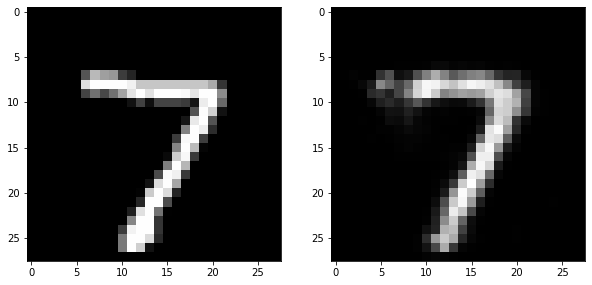

51 12.586123598664045 13.490362392827725
52 12.534902771907067 12.424135494536866
53 12.26653335343546 13.983857907426243
54 12.25126797066738 11.647727088806347
55 12.247575755820854 12.14754837084883
56 12.015597074355483 11.663330955627247
57 12.189390669160474 10.563448311802679
58 11.874132314978887 11.594711084335376
59 11.861852020936057 11.973015416544467
60 11.64815812426081 11.180484467040236
61 11.824374889598811 11.3946807422577
62 11.530256622466283 13.172872646928976
63 11.63661352725595 11.49940802723455
64 11.255887485007996 14.401870825039312
65 11.26166499177869 11.095003511958991
66 11.423749428907014 14.472574520415773
67 11.03066717282033 10.486228162869097
68 11.186941145494972 11.086691371929913
69 10.96973369302865 14.587098264846558
70 11.016552500124934 10.978706432988469
71 11.059729174171345 10.668103544095073
72 10.880520406477656 12.015919158253045
73 11.018674653899863 10.069679967130716
74 10.808706021935869 11.136754532591603
75 10.80055000939603 10.726

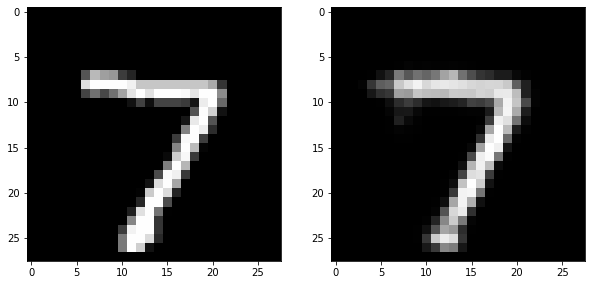

101 9.51788445034176 10.954466920310317
102 9.420777847517781 10.17176197283565
103 9.796286842546824 10.543796868369983
104 9.614743133089435 11.672977508447422
105 9.58271211517052 8.939026220157123
106 9.367607886687864 8.853197920436676
107 9.373307277568282 9.599153512582992
108 9.339365896131438 10.431053356621593
109 9.370506020920786 10.013154416800306
110 9.336427521858134 11.247306409354408
111 9.217556745343456 7.612702049767248
112 9.223585778123194 9.909514747107753
113 9.271343927986672 9.878923873170116
114 9.318911690024002 9.834892809200591
115 9.201563197327744 9.934087393763727
116 9.241323410066714 10.328173311373677
117 9.329751362424416 9.280211110465443
118 9.33110031203844 9.693269016643683
119 9.038702942415087 8.178018417602148
120 9.065376438989484 8.553864402892872
121 9.118035902770258 9.199138970420764
122 9.068968750520556 10.50480664043
123 9.177804715089453 9.981607455415086
124 9.115034199642135 9.952951790806585
125 9.125519102485619 8.37564589040348


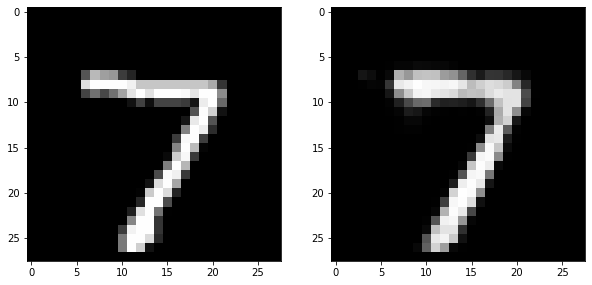

151 9.352735442139192 9.100250487891248
152 8.741442042542587 9.567044291633387
153 8.802069039741305 7.181791092260196
154 8.81664431205267 9.312145854718388
155 8.76783659175176 8.661605006208816
156 8.716897466967271 9.590959713481867
157 8.583630212758058 9.811989464318028
158 8.782650571387968 11.27090073850589
159 8.521513564076589 10.373906485950604
160 8.51890954923867 8.895722118048623
161 8.524624768265953 9.768550202488518
162 8.423279556892574 7.9385331613948935
163 8.63193828634277 9.421983590902993
164 8.382770926035628 8.284746602701302
165 8.29933676756945 10.310527350575018
166 8.436536597798883 9.290725318006814
167 8.265975605111302 7.719633669137193
168 8.317138313992954 7.761811545862558
169 8.941256151016333 7.777327954959564
170 8.214631938053177 9.80644350387037
171 8.299389945588048 9.479469591817155
172 8.22352462367293 8.570855454514964
173 8.321922573368857 8.183663438303402
174 8.501231358249559 9.694870311992998
175 8.27559256265582 9.902230966586275
176 8

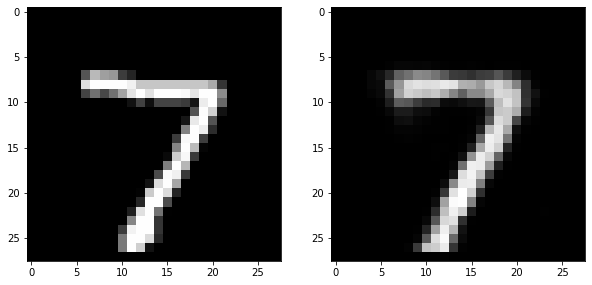

In [ ]:
n_epochs = 201

losses = []
val_losses = []

for e in range(n_epochs):   
    loss_epoch = 0
    cpt_batch = 0
    
    for x_batch, _ in train_loader:
        x_batch = x_batch.to(device)
        
        model.train()
        
        yhat, mu, log_sigma, log_det = model(x_batch.reshape(-1,28,28))
        yhat = yhat.reshape(-1,1,28,28)
        
        l = vae_loss(x_batch, yhat, mu, log_sigma, log_det)
        
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_epoch += l.item()/x_batch.size(0) ## Mean
        cpt_batch += 1
        
    losses.append(loss_epoch/cpt_batch)
    
    loss_val_epoch = 0
    cpt_batch = 0
        
    with torch.no_grad():
        for x_val, _ in test_loader:
            x_val = x_val.to(device)
            
            model.eval()
            yhat, mu, log_sigma, log_det = model(x_val.reshape(-1,28,28))
            yhat = yhat.reshape(-1,1,28,28)
            
            val_l = vae_loss(x_val,yhat,mu,log_sigma,log_det)
            loss_val_epoch += val_l.item()/x_val.size(0)
            cpt_batch += 1
            
        val_losses.append(loss_val_epoch/cpt_batch)
    
    print(e,losses[-1],val_losses[-1])
        
    if e%50 == 0:  
        for x_val, _ in test_loader:
            fig,ax = plt.subplots(1,2,figsize=(10,10))

            ax[0].imshow(x_val[0][0],"gray")

            x_val = x_val.to(device)

            model.eval()
            yhat, mu, sigma, log_det = model(x_val[0][0].reshape(-1,28,28))
            yhat = yhat.reshape(-1,1,28,28)
            ax[1].imshow(yhat[0][0].cpu().detach().numpy(),"gray")
            plt.show()
            break
        

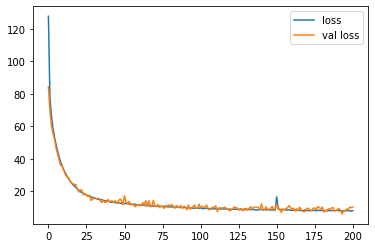

In [ ]:
plt.plot(losses,label="loss")
plt.plot(val_losses,label="val loss")
plt.legend()
plt.show()

To do:
- Log Likelihood estimation
- Check ELBO (surprisingly low values)

## References

<a id="reference1"></a>

[1] Kingma, D.T., Salimans, T., Jozefowicz, R., Chen, Xi,. Sutskever, I., & Welling, M. Improving Variational Inference with Inverse Autoregressive Flow. arXiv preprint arXiv:1606.04934. (2016). [link](https://arxiv.org/pdf/1606.04934)